### Lab 6: Sequence Alignment

In [1]:
# Imports
from os import listdir
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import operator

### Align the reads to the human genome

**What will you use for the database? Input reads?**  
The database will be the bowtie2 database files (.bt2 extension) containing the human genome (hg19.) The input reads will be the reads from the Illumina sequencing run (illumina_reads.fastq.)  

**If you use the --un unaligned.fastq option, what will unaligned.fastq contain?**  
unaligned.fastq will contain the sequencing reads that didn't align to the human genome.  


    be131-12@meowth:~$ bowtie2 -p 4 --fast -- no-unal -x /data/hg19/hg19 -U /data/lab6/illumina_reads.fastq -S hg_aligned.sam --un hg_unaligned.fastq  

    1124714 reads; of these:  
        1124714 (100.00%) were unpaired; of these:  
        1028346 (91.43%) aligned 0 times  
        86808 (7.72%) aligned exactly 1 time  
        9560 (0.85%) aligned >1 times  
    8.57% overall alignment rate  


**What percentage of your sequencing library came from contaminating human DNA?**  
8.57%

### Align the reads to the *S. oneidensis* reference genome

    be131-12@meowth:~$ bowtie2 -p 4 --fast --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U hg_unaligned.fastq -S so_aligned.sam --un so_unaligned.fastq

    1028346 reads; of these:
        1028346 (100.00%) were unpaired; of these:
        299342 (29.11%) aligned 0 times
        687579 (66.86%) aligned exactly 1 time
        41425 (4.03%) aligned >1 times
    70.89% overall alignment rate  


**If you use the --un unaligned.fastq option, what will unaligned.fastq contain?**  
unaligned.fastq will contain the sequencing reads that didn't align to either the human genome or the *S. oneidensis* genome.  

**What percentage of your filtered library didn’t align to the reference genome? If you use --very-sensitive instead of --very-fast, does this percentage increase or decrease?**  
29.11% of the filtered library didn't align to the reference genome because there was a 70.89% overall alignment rate. This was obtained using the --fast parameter. This percentage decreased slightly to 28.99% when using the --very-sensitive parameter (overall alignment rate increased to 71.01%.) The point of this parameter seems to be giving users the ability to adjust the trade-off between speed and sensitivity/accuracy. The sensitivity parameter itself likely decreases the alignment score threshold needed for reads to be considered "aligned", or increases the number of allowed mismatches, as sensitivity goes from less sensitive (toward --very-fast) to more sensitive (toward --very-sensitive.) 

More trials confirm this idea:  
--very-fast and --fast had same alignment (70.89%)  
--very-sensitive and --fast had same alignment for first alignment to human genome (8.57%)  
--very-sensitive increases alignment for alignment to *S. oneidensis* (70.89% to 71.01%)  

### Generate a coverage plot  
First need to convert SAM file of alignment of filtered reads to *S. oneidensis* reference genome to BAM, sort it, index it, and use "depth" to generate a file containing the depth of coverage for every position in the reference genome.

#### Terminal commands:  

    samtools view -b so_aligned.sam > so_aligned.bam
    output: so_aligned.bam

    samtools sort so_aligned.bam > so_aligned_sorted.bam
    output: so_aligned_sorted.bam
    
    samtools index so_aligned_sorted.bam
    output: so_aligned_sorted.bam.bai
    
    samtools depth -a so_aligned_sorted.bam > pileup.tab
    output: pileup.tab
    


In [2]:
# Parse position and coverage info from pileup.tab
pileups = open('pileup.tab', 'r')
cov_dict = {}
for line in pileups:
    cov_dict[int(line.split()[1])] = int(line.split()[2])

**What is the min, max, and mean coverage across all positions?**  

In [3]:
max_info = max(cov_dict.items(), key=operator.itemgetter(1))
print('Maximum coverage of ' + str(max_info[1]) + ' first occurs at position ' + str(max_info[0]))

min_info = min(cov_dict.items(), key=operator.itemgetter(1))
print('Minimum coverage of ' + str(min_info[1]) + ' first occurs at position ' + str(min_info[0]))

coverages = cov_dict.values()
mean_cov = sum(coverages)/len(coverages)
print('Mean coverage = {:.3f}'.format(mean_cov))

Maximum coverage of 269 first occurs at position 3699266
Minimum coverage of 0 first occurs at position 1
Mean coverage = 36.966


In [4]:
# For plotting, parse info from pileup.tab again because sorting cov_dict takes too long
pileups = open('pileup.tab', 'r')
positions = []
coverages = []
for line in pileups:
    positions.append(int(line.split()[1]))
    coverages.append(int(line.split()[2]))

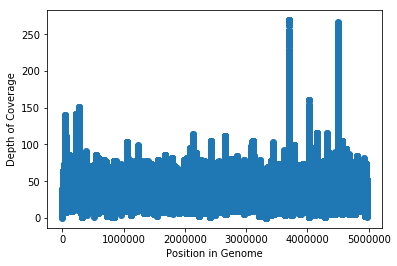

In [5]:
# Plot coverage vs. position
# Plot length    Time
#   100000       3:45
plot_min = 0
plot_max = len(positions)  # takes too long
plt.figure()
plt.scatter(positions[plot_min:plot_max], coverages[plot_min:plot_max])
plt.xlabel('Position in Genome')
plt.ylabel('Depth of Coverage')
plt.show()

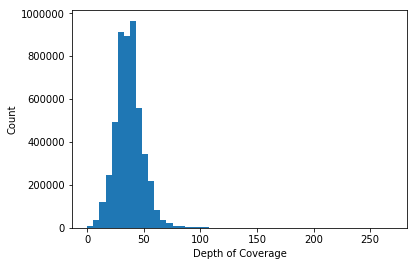

In [6]:
# Plot histogram of depths of coverages
num_bins = 50
plt.figure()
plt.hist(coverages, num_bins)
plt.xlabel('Depth of Coverage')
plt.ylabel('Count')
plt.show()

### Extra Credit 1
#### First need to convert SAM file of alignment to hg19 to BAM, sort it, and index it.   

    samtools view -b hg_aligned.sam > hg_aligned.bam
    output: hg_aligned.bam

    samtools sort hg_aligned.bam > hg_aligned_sorted.bam
    output: hg_aligned_sorted.bam
    
    samtools index hg_aligned_sorted.bam
    output: hg_aligned_sorted.bam.bai  

#### Next split by chromosome for chr1 - 22, X, and Y.  

    samtools view -b hg_aligned_sorted.bam chr1 > chr1.bam
    samtools view -b hg_aligned_sorted.bam chr2 > chr2.bam
                            ...
    samtools view -b hg_aligned_sorted.bam chrX > chrX.bam
    samtools view -b hg_aligned_sorted.bam chrY > chrY.bam  

#### Finally, get coverage at each position and divide by the chromosome lengths for hg19 from NCBI to get average depth  
[Table of Chromosome Lengths](http://dldcc-web.brc.bcm.edu/lilab/liguow/RSeQC/dat/sample.hg19.chrom.sizes)

    samtools depth chr1.bam > chr1.tab
    samtools depth chr2.bam > chr2.tab
                   ...
    samtools depth chrX.bam > chrX.tab
    samtools depth chrY.bam > chrY.tab  
    

In [7]:
# Construct dictionary with chromosome length information from link above (I'm sure there's a faster way to do this)
chr_lens = {'chr1': 1249250621, 'chr2': 243199373, 'chr3': 198022430,
            'chr4': 191154276, 'chr5': 180915260, 'chr6': 171115067,
            'chr7': 159138663, 'chrX': 155270560, 'chr8': 146364022,
            'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516,
            'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540,
            'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210,
            'chr18': 78077248, 'chr20': 63025520, 'chrY': 59373566,
            'chr19': 59128983, 'chr22': 51304566, 'chr21': 48129895}

In [8]:
# Parse position and coverage info from each chromosome's .tab
tabs = [f.split('.')[0] for f in listdir() if f.startswith('chr') and f.endswith('.tab')]
chr_info = []
for chr_name in tabs:
    pileups = open(chr_name + '.tab', 'r')
    positions = []
    coverages = []
    for line in pileups:
        positions.append(int(line.split()[1]))
        coverages.append(int(line.split()[2]))
    mean_cov = sum(coverages)/chr_lens[chr_name]
    
    chr_num = chr_name[3:]    # each file name starts with 'chr'
    if chr_num != 'X' and chr_num != 'Y':
        chr_info.append((int(chr_num), mean_cov))
    elif chr_num == 'X':
        chr_info.append((23, mean_cov))
    else:
        chr_info.append((24, mean_cov))

In [9]:
# Sort average depths by chromosome for plotting
chr_sorted = sorted(chr_info, key=lambda x: x[0])
chromosomes = [num[0] for num in chr_sorted]
depths = [depth[1] for depth in chr_sorted]

# Make xlabels pretty
xlabels = []
for num in chromosomes:
    if num == 23:
        xlabels.append('X')
    elif num == 24:
        xlabels.append('Y')
    else:
        xlabels.append(str(num))

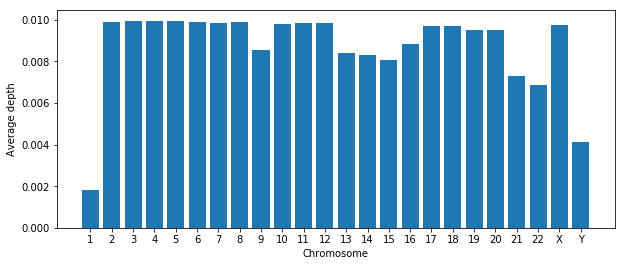

In [10]:
# Plot average depth for each human chromosome
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(chromosomes, depths)
plt.xlabel('Chromosome')
plt.ylabel('Average depth')
plt.xticks(np.arange(1, len(chromosomes)+1, 1))
ax.set_xticklabels(xlabels)
plt.show()

Jamie is male because his plot of average depth has non-zero coverage for the Y chromosome.